In [1]:
import pandas as pd
import numpy as np
import math
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

from fbprophet import Prophet
from pyramid.arima import auto_arima

from sklearn.metrics import mean_absolute_error


def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

# Plotting functions

In [2]:
def plotting_features(exog, mode):
    """
    plotting features
    """
    
    if mode == 'prophet':
        Exog = exog.values
        
    elif mode == 'pyramid':
        Exog = exog

    else:
        print("check mode")
        return None
    
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    
    #left  = 0.125  # the left side of the subplots of the figure
    #right = 0.9    # the right side of the subplots of the figure
    #bottom = 0.1   # the bottom of the subplots of the figure
    #top = 0.9      # the top of the subplots of the figure
    #wspace = 0.2   # the amount of width reserved for blank space between subplots
    #hspace = 0.2   # the amount of height reserved for white space between subplots
    
    fig.subplots_adjust(top=2, bottom=1,  right=2, left=0, wspace=0.6)
    

    ax1.plot(Time,Exog[:,0])
    ax1.set_ylabel('exog_1', bbox=box)


    ax3.set_ylabel('exog_2',bbox=box)
    ax3.plot(Time,Exog[:,1])

    labelx = -0.3  # axes coords

    ax2.plot(Time,Exog[:,2])
    ax2.set_ylabel('exog_3', bbox=box)
    ax2.yaxis.set_label_coords(labelx, 0.5)


    ax4.plot(Time,Exog[:,3])
    ax4.set_ylabel('exog_4', bbox=box)
    ax4.yaxis.set_label_coords(labelx, 0.5)

    plt.show()
    
    pass

In [3]:
def plotting_time_series(y_without_lags, y_with_lags, mode):
    """
    Plot two time series
    """
    if mode == 'prophet':
        ts_without_lags = data_without_lags["y"].values
        ts_with_lags = data_with_lags["y"].values
        
    elif mode == 'pyramid':
        ts_without_lags = y_without_lags
        ts_with_lags = y_with_lags
        
    else:
        print("Check mode")
    
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize = (3, 7))
    fig.subplots_adjust(top = 2, bottom = 1,  right = 2, left = 0, hspace = 0.2)

    ax1.plot(Time, ts_without_lags)
    ax1.set_ylabel("value", bbox = box)
    ax1.set_title("y without lags", bbox = box)


    ax2.set_ylabel("value", bbox = box)
    ax2.plot(Time, ts_with_lags)
    ax2.set_title("y with lags", bbox = box)

    #fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

    plt.show()
    
    pass

In [4]:
def plot_results(time_series, Time, train_prediction, test_prediction, y_test, mode, description):
    
    """
    Plots the original time series and it prediction
    """
    if mode == 'prophet':
        ts = time_series["y"].values
        train_pr = train_prediction["yhat"].values
        test_pr = test_prediction["yhat"].values
    
    elif mode == 'pyramid':
        train_pr = train_prediction
        test_pr = test_prediction
        ts = time_series
        
    
    else:
        print("Check mode")
        return None
    
    plt.figure(figsize=(10,7))

    plt.plot(Time, ts, label = "true")
    
    plt.plot(Time[start_point+1: end_point], np.concatenate([train_pr, test_pr])[1:], 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(
             np.round(mean_absolute_percentage_error(test_pr, y_test), 3),
             np.round(mean_absolute_error(test_pr, y_test), 3)))


    plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

    plt.xlabel("time", size = 20)
    plt.ylabel("value", size = 20)
    plt.title("{}".format(description), size = 20)


    plt.legend(fontsize = 15)

    plt.show()
    pass

# Extra functions

In [16]:
Time = np.arange(200)

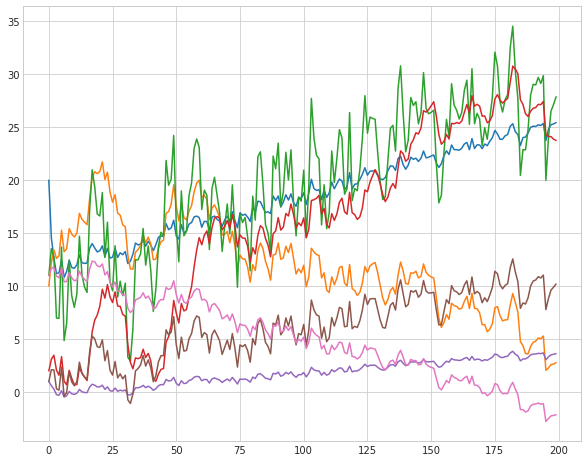

In [17]:
plt.figure(figsize=(10,8))
plt.plot(f_1(Time,10,0.3,0.5,1,+0.05) + 10)
plt.plot(f_1(Time,5,0.85,1,2,-0.01) + 5)
plt.plot(f_1(Time,1,0.5,3,0,0.05) + 10)

plt.plot(f_1(Time,2,1,1,0.1,0))
plt.plot(f_1(Time,1,0.5,0.2,-0.1,0.01))
plt.plot(f_1(Time,1,0.6,1,0.5,0.02))
plt.plot(f_1(Time,1,0.7,0.5,0.5,-0.02) + 10)

plt.show()

In [7]:
def generate_problem_synthetic_2_AR(n_elements, mode = 'prophet', seed = 123):
    """
    Generates time-series, Exog, Time
    """
    # random seed
    np.random.seed(seed)
    
    Time = np.arange(0, n_elements)
    
    # generate exog features
    Exog = np.concatenate([f_1(Time,2,1,1,0.1,0), 
                           f_1(Time,1,0.5,0.2,-0.1,0.01), 
                           f_1(Time,1,0.6,1,0.5,0.02),
                           f_1(Time,1,0.7,0.5,0.5,-0.02) + 10,
                           
                           f_1(Time,10,0.3,0.5,1,+0.05) + 10,
                           f_1(Time,5,0.85,1,2,-0.01) + 5,
                           f_1(Time,1,0.5,3,0,0.05) + 10], axis = 1)
    
    # generate time-series
    y_without_lags = generate_ts_1(Exog)
    
    y_with_lags = generate_ts_2(Exog)
    
    
    if mode == 'prophet':
        
        # generate data frame
        data_without_lags = pd.DataFrame(y_without_lags)
        data_without_lags.columns = ["y"]
        data_without_lags["ds"] = pd.date_range(start='1/1/2018', periods=len(data_without_lags), freq='M')

        data_with_lags = pd.DataFrame(y_with_lags)
        data_with_lags.columns = ["y"]
        data_with_lags["ds"] = pd.date_range(start='1/1/2018', periods=len(data_with_lags), freq='M')

        exog = pd.DataFrame(Exog)
        exog.columns = ["f1", "f2", "f3", "f4", "f5", "f6", "f7"]
        exog["ds"] = pd.date_range(start='1/1/2018', periods=len(exog), freq='M')
    
        return (data_without_lags, data_with_lags, exog, Time)
    
    elif mode == 'pyramid':
        return (y_without_lags, y_with_lags, Exog, Time)
    
    else:
        print("Check mode!")
        return None

In [18]:
def train_test_split(data, start_point, middle_point, end_point, mode, exog_flag = False):
    """
    Make train-test-split using input parameters
    """
    
    if mode == 'prophet':
        data_train = data.iloc[start_point: middle_point].copy()
        data_test = data.iloc[middle_point: end_point].copy()
        
        
        if exog_flag == False:
            
            y_test = data_test["y"].values
            del data_test["y"]
            
            return data_train, data_test, y_test
        
        else:
            
            return data_train, data_test
    
    elif mode == 'pyramid':
        
        data_train = data[start_point: middle_point]
        data_test = data[middle_point: end_point]
        
        if exog_flag == False:
            return data_train, data_test, data_test
        else:
            return data_train, data_test
        
    else:
        print("Check mode")
        return None, None, None

In [19]:
def Fit(mode, data_train, exog_train = None, params = None):
    
    """
    Fit the models
    """
    
    if mode == 'prophet':
        model = fit_prophet(data_train = data_train, exog_train = exog_train, params = params)
        
    elif mode == 'pyramid':
        model = fit_pyramid(data_train = data_train, exog_train = exog_train, params = params)
        
    else:
        print("Check mode")
        model = None
        
    return model

In [20]:
def Predict(mode, model, data_train, data_test, exog_train = None, exog_test = None, params = None):
    """
    Model prediction on train and test
    """
    
    if mode == 'prophet':
        model = predict_prophet(model = model, data_train = data_train, data_test = data_test, 
                                exog_train = exog_train, exog_test = exog_test, params = params)
        
    elif mode == 'pyramid':
        model = predict_pyramid(model = model, 
                                exog_train = exog_train, exog_test = exog_test, params = params)
        
    else:
        print("Check mode")
        model = None
        
    return model

In [21]:
def fit_prophet(data_train, exog_train = None, params = None):
    
    """
    Method fit for prophet
    """
    
    data_train_new = data_train.copy()
    
    model = Prophet()
    
    if exog_train is not None:
        
        data_train_new = pd.merge(data_train_new, exog_train, on = "ds")
        
        model.add_regressor("f1")
        model.add_regressor("f2")
        model.add_regressor("f3")
        model.add_regressor("f4")
    
    model.fit(data_train_new)
    
    return model

In [22]:
def predict_prophet(model, data_train, data_test, exog_train = None, exog_test = None, params = None):
    """
    Prediction for prophet
    """
    
    data_test_new = data_test.copy()
    data_train_new = data_train.copy()
    
    if exog_train is not None:
        data_train_new = pd.merge(data_train_new, exog_train, on = "ds")
        data_test_new = pd.merge(data_test_new, exog_test, on = "ds")
    
    forecast_train = model.predict(data_train_new)
    forecast_test = model.predict(data_test_new)
    
    return forecast_train, forecast_test

In [23]:
def fit_pyramid(data_train, exog_train = None, params = None):

    """
    pyramid_mode {"stepwise", "random_search"}

    """
    
    if params['pyramid_mode'] == "stepwise":
        model = auto_arima(data_train, exogenous=exog_train, start_p=0, start_q=0, max_p=5, max_q=5,
        m=params['period'], n_jobs = params['n_jobs'], scoring = params['scoring'], 
        out_of_sample_size = params['out_of_sample_size'], 
        start_P=0, start_Q = 0, max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=False,
        error_action='ignore', information_criterion = params['ic'], trend = params['trend'],
        suppress_warnings=True, stepwise=True)
    
    elif params['pyramid_mode'] == 'random_search':
        model = auto_arima(data_train, exogenous=exog_train, start_p=0, start_q=0, max_p=5, max_q=5, 
        m=params['period'], scoring = params['scoring'], out_of_sample_size = params['out_of_sample_size'],
        start_P=0, start_Q = 0, n_jobs=params['n_jobs'], max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=False,
        error_action='ignore', information_criterion = params['ic'], trend = params['trend'],
        suppress_warnings=True, seasonal = params['seasonal'],
        stepwise=False, random=True, random_state=params['random_state'], n_fits = params['n_fits'])
    
    return model

In [24]:
def predict_pyramid(model, exog_train = None, exog_test = None, params = None):
    
    predict_in_sample = model.predict_in_sample(exogenous = exog_train, dynamic = params['dynamic'])
    predict_out_of_sample = model.predict(n_periods = params['n_periods'], exogenous = exog_test)
    
    return predict_in_sample, predict_out_of_sample

# Data generation functions

In [120]:
def f_1(time,start,k,sigma,c,ct,seed = 123):
    """
    time: np.array (len_ts,)
    k: parameter of AR(1)
    sigma: variance of noise
    c: constant part of trend
    ct : koef of linear part of trend
    """
    len_ts = time.shape[0]
    np.random.seed(seed)
    f = np.empty(len_ts)
    f[0] = start
    w = np.random.normal(size = len_ts, scale = sigma)
    for i in range(1,len_ts):
        f[i] = k * f[i-1] + c +ct * i + w[i]    
    return f.reshape(-1,1)

def generate_ts_1(exog):
    """
    exog: np.array (len_ts, k_exog)
    """
    a = np.array([0.25,0.25,0.25,0.25,0,0,0]).reshape(-1,1)
    y = exog @ a
    return y.squeeze()

def generate_ts_2(exog):
    y = np.zeros(exog.shape[0])
    a = np.array([0.25,0.25,0.25,0.25,0,0,0]).reshape(-1,1)
    for i in range(exog.shape[0]):
        y[i] = exog[i] @ a
        if (y[i-1] != None):
            y[i] = y[i] + 0.3 * y[i-1]
        if (y[i-2] != None):
            y[i] = y[i] + 0.2 * y[i-2]
        if (y[i-3] != None):
            y[i] = y[i] + 0.1 * y[i-3]
    return y


def generate_ts_nonlinear(exog):
    
    """
    exog: np.array (len_ts, number_exog), number_exog = 4
    """
    
    y = 0.4 * exog[:, 1] * exog[:, 2] + exog[:, 2] / exog[:, 3]
    
    return y

def generate_ts_nonlinear_with_lags(exog):
    
    """
    exog: np.array (len_ts, number_exog), number_exog = 4
    """
    
    y = 0.4 * exog[:, 0] * exog[:, 2] + exog[:, 1] / exog[:, 2]
    
    for i in range(2, exog.shape[0]):
        
        y[i] = y[i] + 0.2 * y[i-1] + 0.2 * y[i-2] + 0.1 * y[i-1]
        
    return y

# Prophet

In [121]:
# Global_mode
global_mode = 'prophet'

# Generate problem

In [122]:
n_samples = 200
data_without_lags, data_with_lags, exog, Time = generate_problem_synthetic_2_AR(n_samples, mode = global_mode, seed = 123)

# Plotting

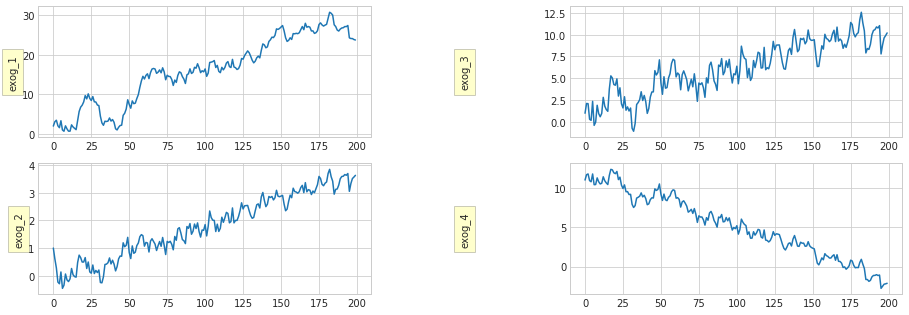

In [123]:
plotting_features(exog, global_mode)

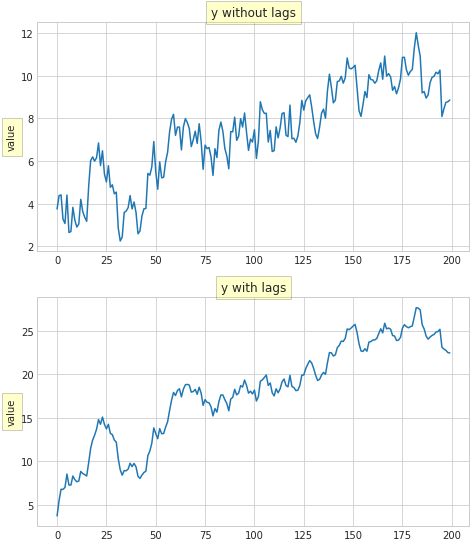

In [124]:
plotting_time_series(data_without_lags, data_with_lags, mode = global_mode)

# Train-test-split

In [125]:
start_point = 0
middle_point = 100
end_point = 200

data_train_without_lags, data_test_without_lags, y_test_without_lags = train_test_split(data_without_lags, start_point, 
                                           middle_point, end_point, global_mode, exog_flag = False)

data_train_with_lags, data_test_with_lags, y_test_with_lags = train_test_split(data_with_lags, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = False)


exog_train, exog_test = train_test_split(exog, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = True)

# Prophet with exogs

In [126]:
params = None
model = Fit(mode = global_mode, data_train = data_train_without_lags, exog_train = exog_train, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nurlan16/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [127]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                        exog_train = exog_train, exog_test = exog_test,
                                           params = params)

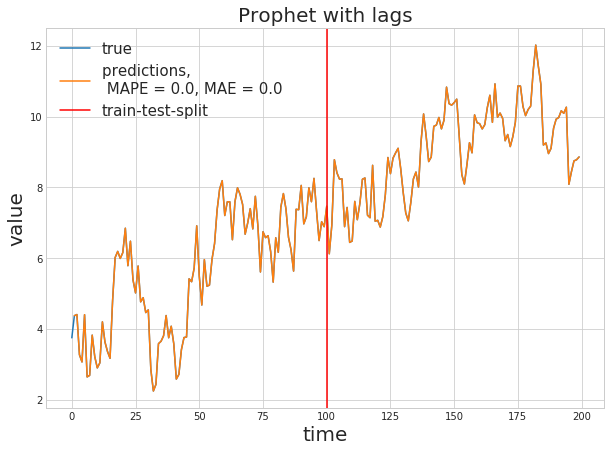

In [128]:
description = "Prophet with lags"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, global_mode, description)

# Pyramid Approach

In [129]:
# Global_mode
global_mode = 'pyramid'

# Generate problem

In [130]:
n_samples = 200
data_without_lags, data_with_lags, exog, Time = generate_problem_synthetic_2_AR(n_samples, mode = global_mode, seed = 123)

# Train-test-split

In [131]:
start_point = 0
middle_point = 100
end_point = 200

data_train_without_lags, data_test_without_lags, y_test_without_lags = train_test_split(data_without_lags, start_point, 
                                           middle_point, end_point, global_mode, exog_flag = False)

data_train_with_lags, data_test_with_lags, y_test_with_lags = train_test_split(data_with_lags, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = False)


exog_train, exog_test = train_test_split(exog, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = True)

# with exog

In [132]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'aic'
params['period'] = 1
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 10
params['dynamic'] = False
params['n_periods'] = end_point - middle_point
params['seasonal'] = False

In [133]:
model = Fit(mode = global_mode, data_train = data_train_without_lags, exog_train = exog_train, params = params)

In [134]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                        exog_train = exog_train, exog_test = exog_test, params = params)

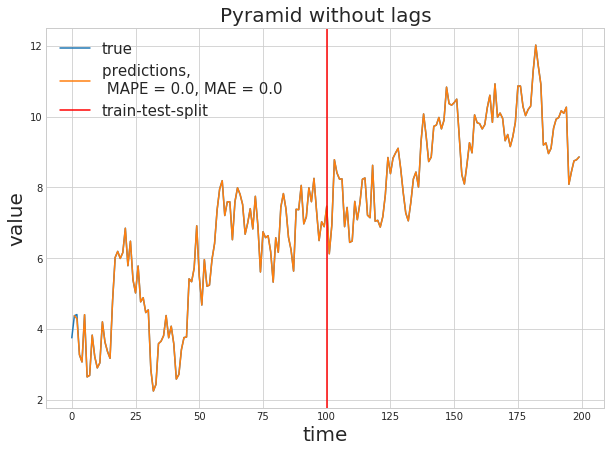

In [135]:
description = "Pyramid without lags"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, global_mode, description)

In [136]:
model.summary()

/home/nurlan16/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/nurlan16/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/nurlan16/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(2, 1, 3)   Log Likelihood                     nan
Date:                Wed, 18 Jul 2018   AIC                                nan
Time:                        17:21:10   BIC                                nan
Sample:                             0   HQIC                               nan
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.833e-17   1.54e-33   3.78e+16      0.000    5.83e-17    5.83e-17
x1             0.2500   1.69e-33   1.48e+32      0.000       0.250       0.250
x2             0.2500   6.02e-34   4.15e+32      0.000       0.250       0.250
x3             0.2500   1.72e-33   1.45e+32      0.000       0.250       0.250
x4             0.2500   1.05e-33   2.39e+32      0.000       0.250       0.250
x5          5.551e-16    8.4e-33   6.61e+16      0.000    5.55e-16    5.55e-16
x6           2.22e-16   3.45e-33   6.44e+16      0.000    2.22e-16    2.22e-16
x7         -5.551e-17   3.92e-33  -1.42e+16      0.000   -5.55e-17   -5.55e-17
ar.L1         -0.0492   8.76e-46  -5.62e+43      0.000      -0.049      -0.049
ar.L2          0.0499    8.5e-46   5.87e+43      0.000       0.050       0.050
ma.L1         -0.0352   9.79e-46   -3.6e+43      0.000      -0.035      -0.035
ma.L2          0.0465   8.68e-46   5.36e+43      0.000       0.047       0.047
ma.L3         -0.0095   4.64e-45  -2.05e+42      0.000      -0.010      -0.010
sigma2      6.104e-31   2.94e-70   2.07e+39      0.000     6.1e-31     6.1e-31
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):             36876.42
Prob(Q):                               nan   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             9.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        96.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.22e+90. Standard errors may be unstable.
"""

# Testing linear case (with lags)

# Prophet

In [137]:
# Global_mode
global_mode = 'prophet'

# Generate problem

In [138]:
n_samples = 200
data_without_lags, data_with_lags, exog, Time = generate_problem_synthetic_2_AR(n_samples, mode = global_mode, seed = 123)

# Train-test-split

In [139]:
start_point = 0
middle_point = 100
end_point = 200

data_train_without_lags, data_test_without_lags, y_test_without_lags = train_test_split(data_without_lags, start_point, 
                                           middle_point, end_point, global_mode, exog_flag = False)

data_train_with_lags, data_test_with_lags, y_test_with_lags = train_test_split(data_with_lags, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = False)


exog_train, exog_test = train_test_split(exog, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = True)

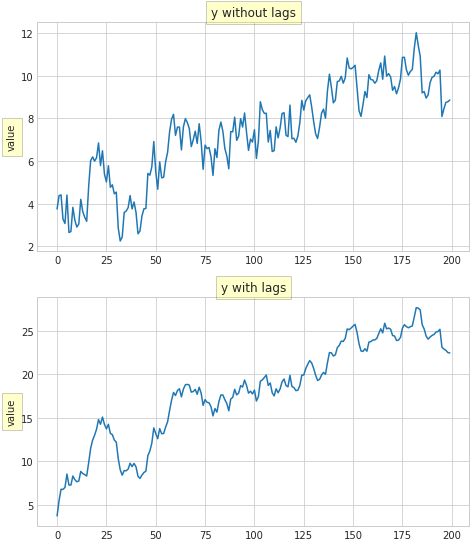

In [140]:
plotting_time_series(data_without_lags, data_with_lags, mode = global_mode)

# Prophet with exogs

In [141]:
params = None
model = Fit(mode = global_mode, data_train = data_train_with_lags, exog_train = exog_train, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nurlan16/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [142]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                        exog_train = exog_train, exog_test = exog_test,
                                           params = params)

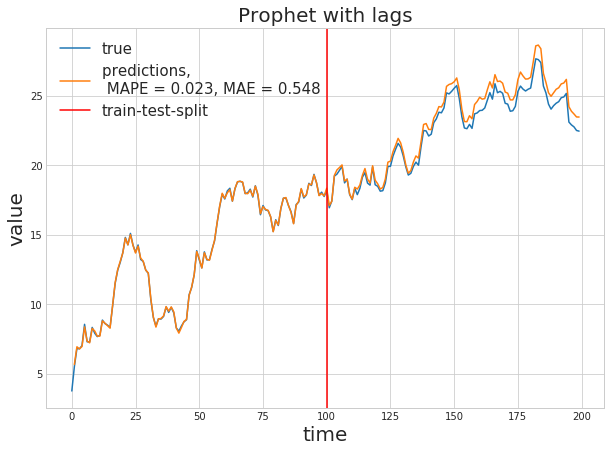

In [143]:
description = "Prophet with lags"
plot_results(data_with_lags, Time, train_prediction, test_prediction, y_test_with_lags, global_mode, description)

# Pyramid Approach

In [144]:
# Global_mode
global_mode = 'pyramid'

# Generate problem

In [145]:
n_samples = 200
data_without_lags, data_with_lags, exog, Time = generate_problem_synthetic_2_AR(n_samples, mode = global_mode, seed = 123)

# Train-test-split

In [146]:
start_point = 0
middle_point = 100
end_point = 200

data_train_without_lags, data_test_without_lags, y_test_without_lags = train_test_split(data_without_lags, start_point, 
                                           middle_point, end_point, global_mode, exog_flag = False)

data_train_with_lags, data_test_with_lags, y_test_with_lags = train_test_split(data_with_lags, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = False)


exog_train, exog_test = train_test_split(exog, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = True)

# with exog

In [147]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'aic'
params['period'] = 1
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 10
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [148]:
model = Fit(mode = global_mode, data_train = data_train_with_lags, exog_train = exog_train, params = params)

In [155]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(3, 0, 0)   Log Likelihood                 158.215
Date:                Wed, 18 Jul 2018   AIC                           -292.430
Time:                        17:22:30   BIC                           -261.168
Sample:                             0   HQIC                          -279.778
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5037      0.114      4.400      0.000       0.279       0.728
x1             0.6297      0.014     46.196      0.000       0.603       0.656
x2            -7.5750      0.415    -18.233      0.000      -8.389      -6.761
x3             1.1801      0.124      9.555      0.000       0.938       1.422
x4            -0.8945      0.028    -31.578      0.000      -0.950      -0.839
x5             0.6160      0.043     14.301      0.000       0.532       0.700
x6             0.2936      0.025     11.551      0.000       0.244       0.343
x7             0.0790      0.030      2.660      0.008       0.021       0.137
ar.L1          1.3188      0.110     12.011      0.000       1.104       1.534
ar.L2         -0.7373      0.125     -5.888      0.000      -0.983      -0.492
ar.L3          0.1881      0.074      2.559      0.010       0.044       0.332
sigma2         0.0022      0.000      5.227      0.000       0.001       0.003
===================================================================================
Ljung-Box (Q):                       44.56   Jarque-Bera (JB):               206.46
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [149]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                        exog_train = exog_train, exog_test = exog_test, params = params)

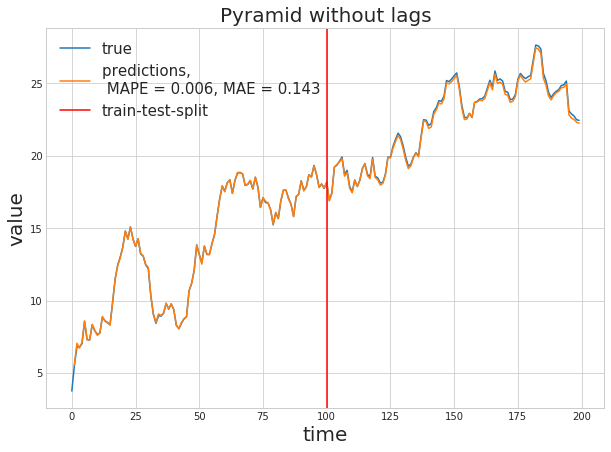

In [150]:
description = "Pyramid without lags"
plot_results(data_with_lags, Time, train_prediction, test_prediction, y_test_with_lags, global_mode, description)